In [1]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

In [2]:
import pandas as pd
import asyncio
import kagglehub
RANDOM_STATE = 123

EMOTIONS_MAPPING = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

path = kagglehub.dataset_download("aadyasingh55/twitter-emotion-classification-dataset")
file_path = path + '/train-00000-of-00001.parquet'
df = pd.read_parquet(file_path)

# Предварительный просмотр данных
df.head()

100%|██████████| 22.3M/22.3M [00:00<00:00, 87.9MB/s]

Extracting files...


,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


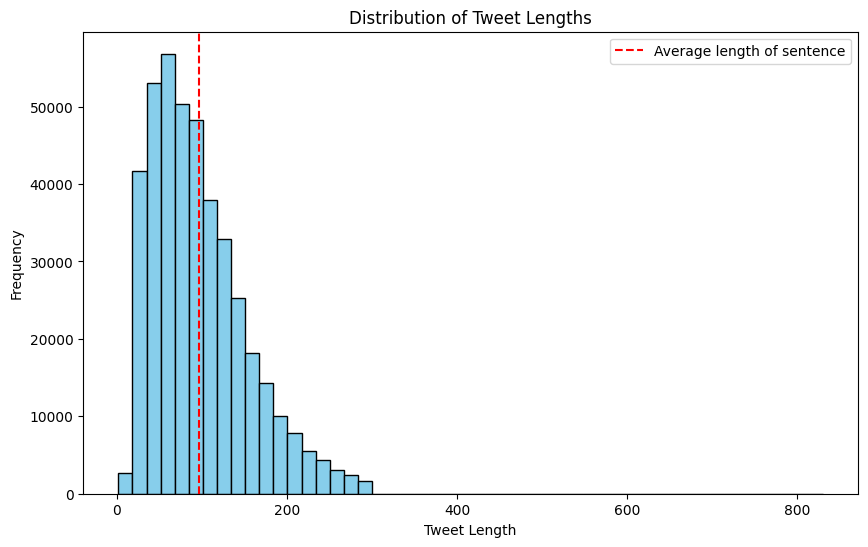

In [5]:
import matplotlib.pyplot as plt


# Визуализация распределения
plt.figure(figsize=(10, 6))
plt.hist(df['text'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=df['text'].apply(len).mean(), color='red', linestyle='--', label='Average length of sentence')
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.legend()
plt.show()


In [7]:
df[df["text_length"] == 0]

,text,label,text_length


In [8]:
df = df.drop("text_length", axis=1)


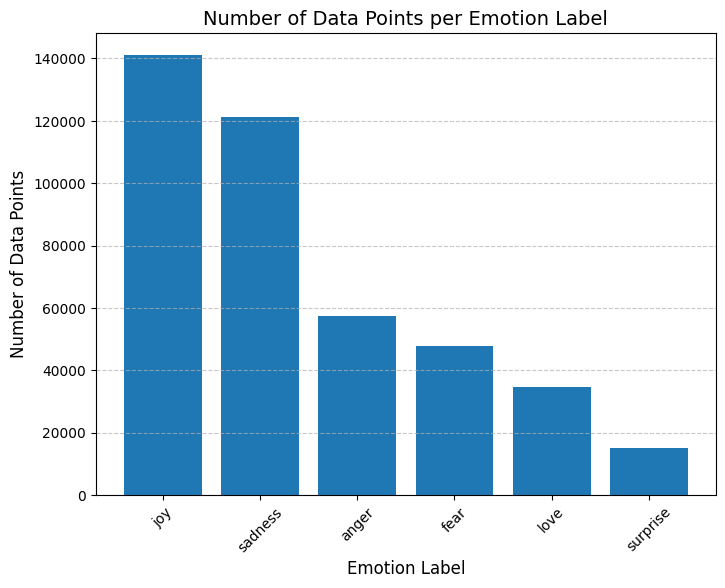

In [ ]:
import matplotlib.pyplot as plt

# Group by label and count the number of occurrences
label_counts = df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index.map(EMOTIONS_MAPPING), label_counts.values)
plt.title("Number of Data Points per Emotion Label", fontsize=14)
plt.xlabel("Emotion Label", fontsize=12)
plt.ylabel("Number of Data Points", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=RANDOM_STATE
)

# Делим временные данные на test и validation в соотношении 50:50
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=RANDOM_STATE
)

# Проверка размеров данных
print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Train size: 333447
Validation size: 41681
Test size: 41681


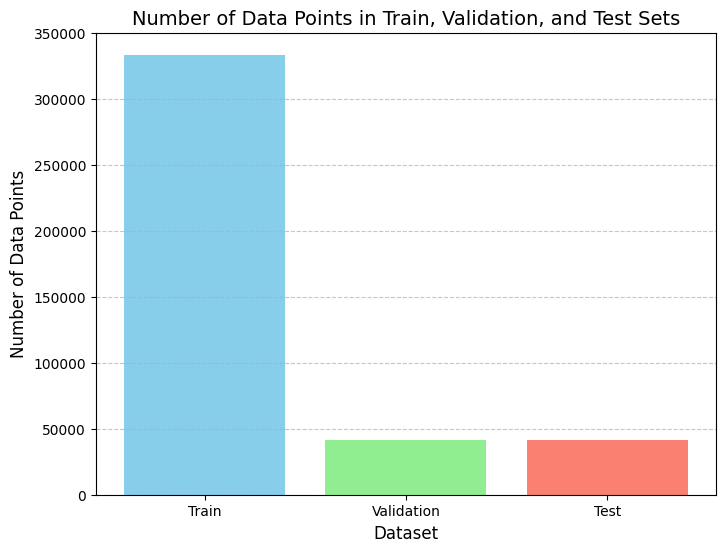

In [ ]:
import matplotlib.pyplot as plt

# Sizes of datasets
dataset_sizes = {
    "Train": len(train_texts),
    "Validation": len(val_texts),
    "Test": len(test_texts),
}

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(dataset_sizes.keys(), list(dataset_sizes.values()), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Number of Data Points in Train, Validation, and Test Sets", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of Data Points", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Токенизация данных
def tokenize_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return inputs, tf.convert_to_tensor(labels)

train_inputs, train_labels = tokenize_data(train_texts, train_labels, tokenizer)
val_inputs, val_labels = tokenize_data(val_texts, val_labels, tokenizer)
test_inputs, test_labels = tokenize_data(test_texts, test_labels, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Компиляция модели
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")


In [ ]:
history = model.fit(
    {"input_ids": train_inputs["input_ids"], "attention_mask": train_inputs["attention_mask"]},
    train_labels,
    validation_data=(
        {"input_ids": val_inputs["input_ids"], "attention_mask": val_inputs["attention_mask"]},
        val_labels
    ),
    epochs=3,
    batch_size=128
)


Epoch 1/3
2606/2606 [==============================] - 3870s 1s/step - loss: 0.1127 - accuracy: 0.9379 - val_loss: 0.0963 - val_accuracy: 0.9403
Epoch 2/3
2606/2606 [==============================] - 3896s 1s/step - loss: 0.0901 - accuracy: 0.9423 - val_loss: 0.0875 - val_accuracy: 0.9413
Epoch 3/3
2606/2606 [==============================] - 3896s 1s/step - loss: 0.0857 - accuracy: 0.9425 - val_loss: 0.0878 - val_accuracy: 0.9411


In [ ]:
# Проверка модели на тестовом наборе
test_loss, test_accuracy = model.evaluate(
    {"input_ids": test_inputs["input_ids"], "attention_mask": test_inputs["attention_mask"]},
    test_labels,
    batch_size=128
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


326/326 [==============================] - 120s 363ms/step - loss: 0.0890 - accuracy: 0.9401
Test Loss: 0.08898752927780151
Test Accuracy: 0.9401406049728394


In [ ]:
model.save_weights("my_model_weights")


NameError: name 'model' is not defined

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)
model.load_weights("my_model_weights")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for my_model_weights

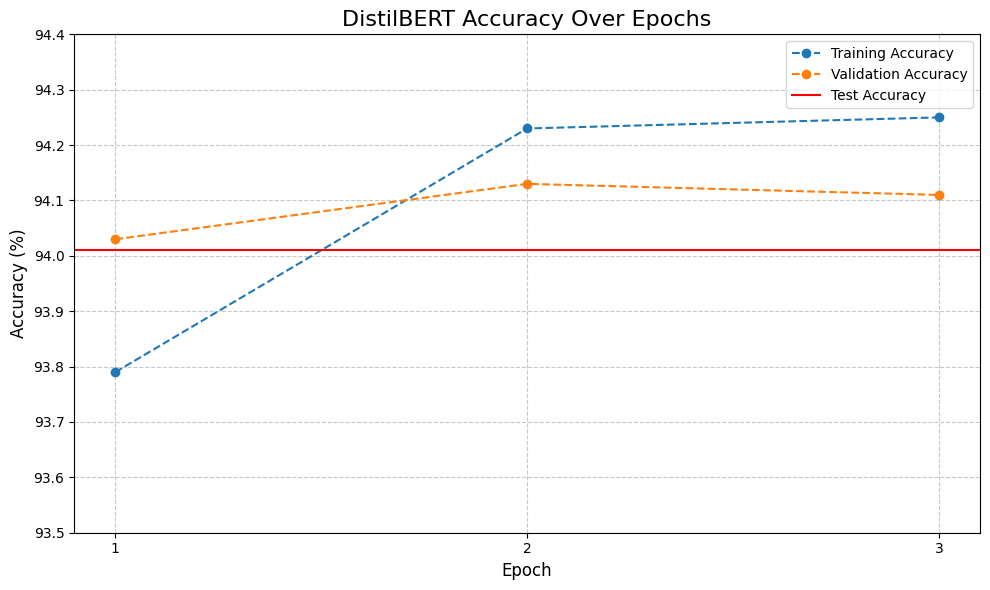

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data for epochs
epochs = [1, 2, 3]
train_accuracy = [93.79, 94.23, 94.25]
val_accuracy = [94.03, 94.13, 94.11]
test_accuracy = [94.01]


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o', linestyle='--')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o', linestyle='--')


plt.axhline(y=test_accuracy[0], color='red', linestyle='-', label="Test Accuracy")


plt.title("DistilBERT Accuracy Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(epochs)
plt.yticks(np.arange(93.5, 94.5, 0.1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
